# First Deep Learning Model


## Importing Libraries and Dataset


In [ ]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Importing the dataset
from datasets import load_dataset

mnist_dataset = load_dataset("mnist")

mnist_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

What the hell is this? You may ask. This is just [Hugging Face's](https://huggingface.co/docs/datasets/index) `datasets` library, which provides a simple way to access and share datasets. `DatasetDict` is a dictionary-like class that holds multiple datasets, typically a training set, validation set, and test set.

Okay, so now we have the MNIST dataset, which is a classic in the machine learning world. It consists of 70,000 images of handwritten digits (0-9), each image being 28x28 pixels in size. The dataset is split into 60,000 training images and 10,000 test images.

In order to use this dataset, you can access the training and test splits as follows:


In [10]:
# Access the training and test splits
train_dataset = mnist_dataset["train"]
test_dataset = mnist_dataset["test"]

# You can then explore the dataset, for example:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Example training sample: {train_dataset[0]}")

Number of training samples: 60000
Number of test samples: 10000
Example training sample: {'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x23E19ACEAD0>, 'label': 5}


Hmmm... let's visualize some of the training samples to get a better understanding of the dataset, because what the hell is `PIL.PngImagePlugin.PngImageFile`?


In [ ]:
def visualize_samples(
    dataset,
    num_samples: int = 10,
    cols: int = 5,
    figsize_scale: float = 1.2,
    is_random: bool = False,
):
    """
    Visualize samples from the dataset.

    Args:
        dataset: The dataset to visualize from.
        num_samples (int, optional): Number of samples to display. Defaults to 10.
        cols (int, optional): Number of columns in the grid. Defaults to 5.
        figsize_scale (float, optional): Figure size scale factor. Defaults to 1.2.
        is_random (bool, optional): Whether to display random samples. Defaults to False.
    """
    # Calculate number of rows needed
    rows = (num_samples + cols - 1) // cols

    # Create subplots
    fig, axes = plt.subplots(
        rows, cols, figsize=(cols * figsize_scale, rows * figsize_scale)
    )

    # Handle case when there's only one row or column
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Generate indices: random or sequential
    if is_random:
        indices = np.random.choice(len(dataset), num_samples, replace=False)
    else:
        indices = range(num_samples)

    # Display images
    for i, idx in enumerate(indices):
        # Get image and label from dataset
        sample = dataset[idx]
        image = sample["image"]
        label = sample["label"]

        # Display the image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    # Hide extra subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

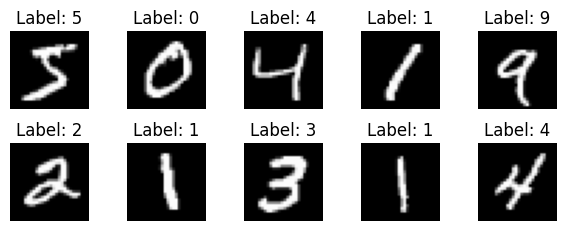

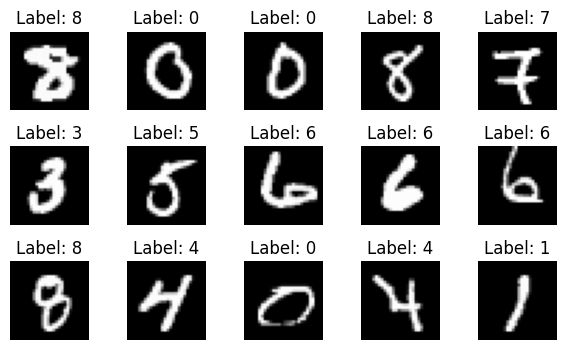

In [49]:
visualize_samples(train_dataset, num_samples=10, cols=5, is_random=False)
visualize_samples(train_dataset, num_samples=15, cols=5, is_random=True)

Hooray! We can see that the images are indeed handwritten digits, and the labels correspond to the correct digit for each image.

That is what we will work on now. And first, let's define a problem and think of a solution...

## Problem Definition

Imagine you are working in a postal service, and you need to sort letters based on the handwritten zip codes. Manually sorting these letters is time-consuming and prone to errors. To automate this process, you decide to build a machine learning model that can recognize handwritten digits from images 28x28 pixels in size.

So, the problem we are trying to solve is: **Given an image of a handwritten digit, classify it into one of the 10 classes (0-9)**.

What kind of model can we use to solve this problem? Think of some simple algorithms that can classify black and white images this way.

## Classification with KNN


We'll implement the K-Nearest Neighbors algorithm from scratch to classify handwritten digits. The algorithm works in three simple steps:

1. Calculate distances to all training samples
2. Find the K closest neighbors
3. Return the most common label among them

Let's start by converting our HuggingFace dataset to NumPy arrays for easier manipulation:


In [ ]:
# Convert dataset to numpy arrays
train_images = np.array([np.array(sample["image"]) for sample in train_dataset])
train_labels = np.array([sample["label"] for sample in train_dataset])

test_images = np.array([np.array(sample["image"]) for sample in test_dataset])
test_labels = np.array([sample["label"] for sample in test_dataset])

# Normalize pixel values to [0, 1] range
train_images = train_images / 255.0
test_images = test_images / 255.0

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

Train images shape: (60000, 28, 28)
Test images shape: (10000, 28, 28)


In [34]:
# Subsample for faster experimentation
train_images_small = train_images[:2000]
train_labels_small = train_labels[:2000]

test_images_small = test_images[:1000]
test_labels_small = test_labels[:1000]

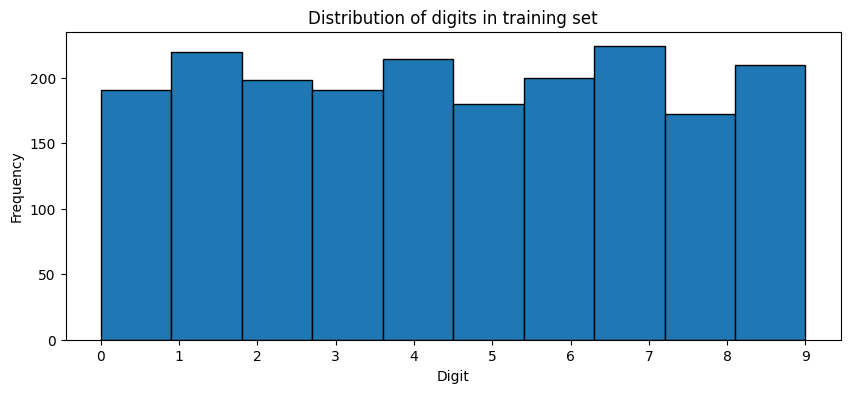

In [ ]:
# Check class distribution
plt.figure(figsize=(10, 4))
plt.hist(train_labels_small, bins=10, edgecolor="black")
plt.xlabel("Digit")
plt.ylabel("Frequency")
plt.title("Distribution of digits in training set")
plt.xticks(range(10))
plt.show()

### Implementing Distance Function


The Euclidean distance (L) between two images is calculated as:

$$L = \sqrt{\sum{(x_1 - x_2)^2}}$$

Let's implement this:


In [ ]:
def euclidean_distance(img1, img2):
    """
    Calculate Euclidean distance between two images.

    Args:
        img1: First image array
        img2: Second image array

    Returns:
        Euclidean distance as float
    """
    return np.sqrt(np.sum((img1 - img2) ** 2))

In [37]:
# Test the distance function
dist_same = euclidean_distance(train_images_small[0], train_images_small[1])
print(f"Distance between first two images: {dist_same:.2f}")

Distance between first two images: 9.36


### Implementing Nearest Neighbor Classifier


Now let's implement the actual NN classifier:


In [ ]:
def classify_nn(test_image, train_images, train_labels):
    """
    Classify a test image using Nearest Neighbor algorithm.

    Args:
        test_image: Image to classify
        train_images: Training images array
        train_labels: Training labels array

    Returns:
        Predicted label
    """
    # Calculate distances to all training images
    distances = [
        euclidean_distance(test_image, train_img) for train_img in train_images
    ]

    # Find index of nearest neighbor
    nearest_idx = np.argmin(distances)

    # Return corresponding label
    return train_labels[nearest_idx]

In [40]:
# Test on a single image
test_image = test_images_small[0]
predicted = classify_nn(test_image, train_images_small, train_labels_small)
actual = test_labels_small[0]

print(f"Predicted: {predicted}, Actual: {actual}")

Predicted: 7, Actual: 7


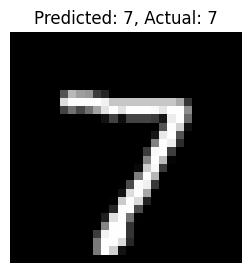

In [ ]:
# Visualize the test image
plt.imshow(test_image, cmap="gray")
plt.title(f"Predicted: {predicted}, Actual: {actual}")
plt.axis("off")
plt.show()

### Evaluating on Test Set


Let's classify all test images and calculate accuracy:


In [ ]:
# Classify all test images (this will take some time)
test_predicted = [
    classify_nn(img, train_images_small, train_labels_small)
    for img in test_images_small
]

In [ ]:
# Calculate accuracy
n_correct = np.sum(test_predicted == test_labels_small)
KNN_accuracy = n_correct / len(test_labels_small)

print(f"Number of correctly classified images: {n_correct}/{len(test_labels_small)}")
print(f"Accuracy: {KNN_accuracy:.2%}")

Number of correctly classified images: 873/1000
Accuracy: 87.30%


### Visualizing Misclassifications


Let's examine some examples where our classifier failed:


In [ ]:
# rewrite visualize_samples function to work with numpy arrays
def visualize_samples_numpy(
    images, labels, num_samples=10, cols=5, figsize_scale=1.2, is_random=False
):
    """
    Visualize samples from numpy arrays.

    Args:
        images: NumPy array of images
        labels: NumPy array of labels
        num_samples: Number of samples to display
        cols: Number of columns in the grid
        figsize_scale: Figure size scale factor
        is_random: Whether to display random samples
    """
    # Calculate number of rows needed
    rows = (num_samples + cols - 1) // cols

    # Create subplots
    fig, axes = plt.subplots(
        rows, cols, figsize=(cols * figsize_scale, rows * figsize_scale)
    )

    # Handle case when there's only one row or column
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Generate indices: random or sequential
    if is_random:
        indices = np.random.choice(len(images), num_samples, replace=False)
    else:
        indices = range(num_samples)

    # Display images
    for i, idx in enumerate(indices):
        # Get image and label directly from arrays
        image = images[idx]
        label = labels[idx]

        # Display the image
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")

    # Hide extra subplots
    for i in range(num_samples, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [51]:
# Find misclassified examples
misclassified_indices = np.where(test_predicted != test_labels_small)[0]

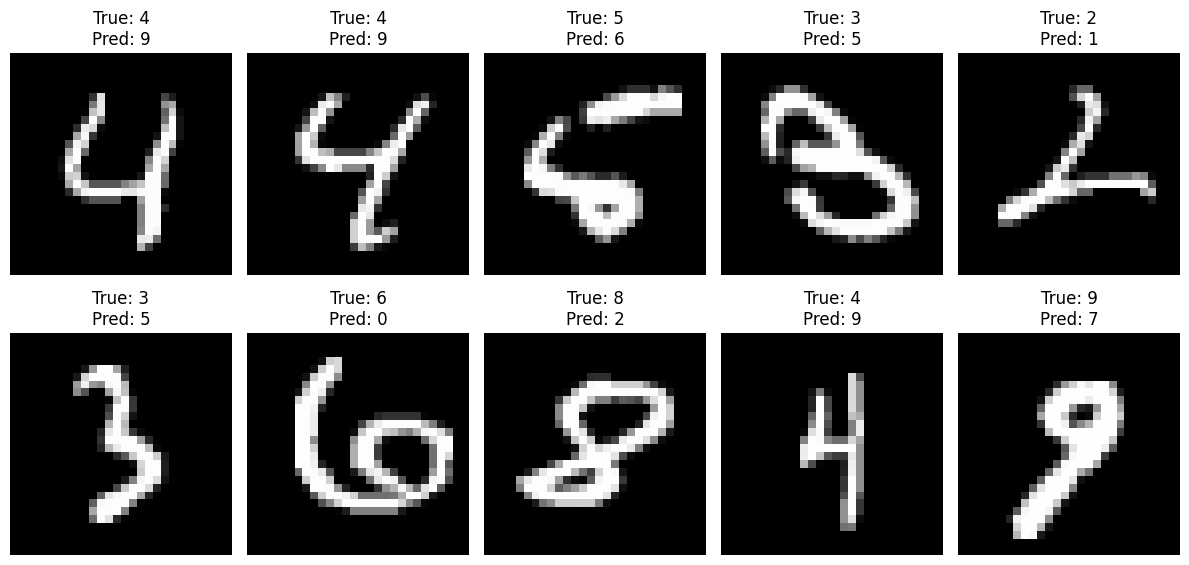

In [ ]:
misclassified_images = test_images_small[misclassified_indices]
true_labels = test_labels_small[misclassified_indices]
predicted_labels = np.array(test_predicted)[misclassified_indices]

# Visualize misclassifications with both true and predicted labels
want_to_show = 10
num_to_show = min(want_to_show, len(misclassified_indices))
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()

for i in range(num_to_show):
    axes[i].imshow(misclassified_images[i], cmap="gray")
    axes[i].set_title(f"True: {true_labels[i]}\nPred: {predicted_labels[i]}")
    axes[i].axis("off")

# Hide unused subplots
for i in range(num_to_show, 10):
    axes[i].axis("off")

plt.tight_layout()
plt.show()

### Using Scikit-Learn Implementation


Now let's compare our implementation with scikit-learn's optimized version:


In [55]:
pass

## Building a Simple Neural Network from Scratch

Now let's build something more powerful - a simple two-layer neural network! While KNN gave us decent results, neural networks can learn more complex patterns in the data.

### Network Architecture

Our network will have:
- **Input layer**: 784 units (28×28 pixels flattened)
- **Hidden layer**: 10 units with ReLU activation
- **Output layer**: 10 units (one for each digit 0-9) with Softmax activation

Here's how information flows through the network:

**Forward Propagation:**

1. First layer computation:
   $$Z^{[1]} = W^{[1]} \cdot X + b^{[1]}$$
   $$A^{[1]} = \text{ReLU}(Z^{[1]}) = \max(0, Z^{[1]})$$

2. Second layer computation:
   $$Z^{[2]} = W^{[2]} \cdot A^{[1]} + b^{[2]}$$
   $$A^{[2]} = \text{Softmax}(Z^{[2]}) = \frac{e^{Z^{[2]}}}{\sum e^{Z^{[2]}}}$$

**Backward Propagation (how we learn):**

1. Output layer gradients:
   $$dZ^{[2]} = A^{[2]} - Y$$
   $$dW^{[2]} = \frac{1}{m} dZ^{[2]} \cdot A^{[1]T}$$
   $$db^{[2]} = \frac{1}{m} \sum dZ^{[2]}$$

2. Hidden layer gradients:
   $$dZ^{[1]} = W^{[2]T} \cdot dZ^{[2]} \odot \text{ReLU}'(Z^{[1]})$$
   $$dW^{[1]} = \frac{1}{m} dZ^{[1]} \cdot X^T$$
   $$db^{[1]} = \frac{1}{m} \sum dZ^{[1]}$$

3. Update weights:
   $$W^{[i]} := W^{[i]} - \alpha \cdot dW^{[i]}$$
   $$b^{[i]} := b^{[i]} - \alpha \cdot db^{[i]}$$

Where:
- $\alpha$ is the learning rate
- $m$ is the number of training examples
- $\odot$ means element-wise multiplication

### Preparing Data for Neural Network

Before building the network, we need to reshape our data properly:

In [63]:
# Reshape images: (num_samples, 28, 28) -> (784, num_samples)
# Neural networks expect features in rows and samples in columns
X_train_nn = train_images_small.reshape(train_images_small.shape[0], -1).T
X_test_nn = test_images_small.reshape(test_images_small.shape[0], -1).T

Y_train_nn = train_labels_small
Y_test_nn = test_labels_small

print(f"Training data shape: {X_train_nn.shape}")
print(f"Training labels shape: {Y_train_nn.shape}")
print(f"Test data shape: {X_test_nn.shape}")
print(f"Test labels shape: {Y_test_nn.shape}")

Training data shape: (784, 2000)
Training labels shape: (2000,)
Test data shape: (784, 1000)
Test labels shape: (1000,)


### Implementing Neural Network Components

Let's build our neural network step by step:

In [64]:
def init_params():
    """
    Initialize weights and biases with small random values.
    
    Returns:
        W1, b1, W2, b2: Initial parameters for the network
    """
    W1 = np.random.rand(10, 784) - 0.5  # Shape: (10, 784)
    b1 = np.random.rand(10, 1) - 0.5     # Shape: (10, 1)
    W2 = np.random.rand(10, 10) - 0.5    # Shape: (10, 10)
    b2 = np.random.rand(10, 1) - 0.5     # Shape: (10, 1)
    return W1, b1, W2, b2

In [65]:
def relu(Z):
    """
    ReLU activation function.
    
    Args:
        Z: Input values
        
    Returns:
        Element-wise maximum of Z and 0
    """
    return np.maximum(Z, 0)

In [66]:
def relu_derivative(Z):
    """
    Derivative of ReLU function.
    
    Args:
        Z: Input values
        
    Returns:
        1 where Z > 0, else 0
    """
    return Z > 0

In [67]:
def softmax(Z):
    """
    Softmax activation function (converts to probabilities).
    
    Args:
        Z: Input values
        
    Returns:
        Probability distribution over classes
    """
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Numerical stability
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

In [68]:
def one_hot_encode(Y):
    """
    Convert labels to one-hot encoding.
    
    Args:
        Y: Array of labels (e.g., [3, 0, 2, 7])
        
    Returns:
        One-hot encoded matrix (10 x m)
    """
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    return one_hot_Y.T

Now the most important part!

In [69]:
def forward_propagation(W1, b1, W2, b2, X):
    """
    Perform forward propagation through the network.
    
    Args:
        W1, b1: First layer parameters
        W2, b2: Second layer parameters
        X: Input data
        
    Returns:
        Z1, A1, Z2, A2: Intermediate values and activations
    """
    # First layer
    Z1 = W1.dot(X) + b1
    A1 = relu(Z1)
    
    # Second layer
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    
    return Z1, A1, Z2, A2

In [70]:
def backward_propagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    """
    Perform backward propagation to compute gradients.
    
    Args:
        Z1, A1: First layer values
        Z2, A2: Second layer values
        W1, W2: Current weights
        X: Input data
        Y: True labels
        
    Returns:
        dW1, db1, dW2, db2: Gradients for all parameters
    """
    m = Y.size
    one_hot_Y = one_hot_encode(Y)
    
    # Output layer gradients
    dZ2 = A2 - one_hot_Y
    dW2 = (1 / m) * dZ2.dot(A1.T)
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)
    
    # Hidden layer gradients
    dZ1 = W2.T.dot(dZ2) * relu_derivative(Z1)
    dW1 = (1 / m) * dZ1.dot(X.T)
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    return dW1, db1, dW2, db2

In [71]:
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    """
    Update parameters using gradient descent.
    
    Args:
        W1, b1, W2, b2: Current parameters
        dW1, db1, dW2, db2: Gradients
        learning_rate: Step size for updates
        
    Returns:
        Updated parameters
    """
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    return W1, b1, W2, b2

### Training the Neural Network

In [72]:
def get_predictions(A2):
    """
    Convert probabilities to predicted classes.
    
    Args:
        A2: Softmax output (probabilities)
        
    Returns:
        Predicted class labels
    """
    return np.argmax(A2, axis=0)

In [73]:
def get_accuracy(predictions, Y):
    """
    Calculate classification accuracy.
    
    Args:
        predictions: Predicted labels
        Y: True labels
        
    Returns:
        Accuracy as a float between 0 and 1
    """
    return np.sum(predictions == Y) / Y.size

In [74]:
def train_neural_network(X, Y, learning_rate=0.10, iterations=500):
    """
    Train the neural network using gradient descent.
    
    Args:
        X: Training data
        Y: Training labels
        learning_rate: Learning rate for gradient descent
        iterations: Number of training iterations
        
    Returns:
        Trained parameters W1, b1, W2, b2
    """
    # Initialize parameters
    W1, b1, W2, b2 = init_params()
    
    # Training loop
    for i in range(iterations):
        # Forward pass
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
        
        # Backward pass
        dW1, db1, dW2, db2 = backward_propagation(Z1, A1, Z2, A2, W1, W2, X, Y)
        
        # Update parameters
        W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
        
        # Print progress every 50 iterations
        if i % 50 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y)
            print(f"Iteration {i:3d}: Accuracy = {accuracy:.2%}")
    
    return W1, b1, W2, b2

In [75]:
# Train the network
print("Training neural network...")
W1, b1, W2, b2 = train_neural_network(X_train_nn, Y_train_nn, learning_rate=0.10, iterations=500)

Training neural network...
Iteration   0: Accuracy = 11.15%
Iteration  50: Accuracy = 50.55%
Iteration 100: Accuracy = 68.25%
Iteration 150: Accuracy = 75.90%
Iteration 200: Accuracy = 80.25%
Iteration 250: Accuracy = 82.95%
Iteration 300: Accuracy = 84.50%
Iteration 350: Accuracy = 85.80%
Iteration 400: Accuracy = 86.75%
Iteration 450: Accuracy = 87.70%


### Evaluating the Neural Network

In [81]:
def make_predictions(X, W1, b1, W2, b2):
    """
    Make predictions on new data.
    
    Args:
        X: Input data
        W1, b1, W2, b2: Trained parameters
        
    Returns:
        Predicted class labels
    """
    _, _, _, A2 = forward_propagation(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

In [77]:
# Evaluate on training set
train_predictions = make_predictions(X_train_nn, W1, b1, W2, b2)
train_accuracy = get_accuracy(train_predictions, Y_train_nn)
print(f"Training accuracy: {train_accuracy:.2%}")

# Evaluate on test set
test_predictions = make_predictions(X_test_nn, W1, b1, W2, b2)
test_accuracy = get_accuracy(test_predictions, Y_test_nn)
print(f"Test accuracy: {test_accuracy:.2%}")

Training accuracy: 88.40%
Test accuracy: 80.10%


### Visualizing Neural Network Predictions

In [80]:
def test_prediction(index, X, Y, W1, b1, W2, b2):
    """
    Visualize a single prediction.
    
    Args:
        index: Index of image to test
        X: Input data
        Y: True labels
        W1, b1, W2, b2: Trained parameters
    """
    # Make prediction
    current_image = X[:, index, None]
    prediction = make_predictions(current_image, W1, b1, W2, b2)
    label = Y[index]
    
    # Display results
    print(f"Prediction: {prediction[0]}")
    print(f"True label: {label}")
    
    # Show image
    image = current_image.reshape(28, 28)
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted: {prediction[0]}, Actual: {label}')
    plt.axis('off')
    plt.show()

Example predictions:
Prediction: 7
True label: 7


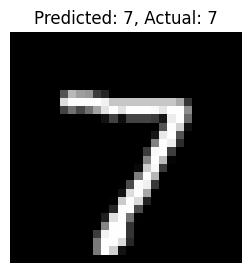

Prediction: 2
True label: 2


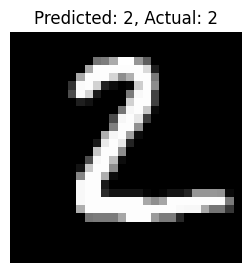

Prediction: 1
True label: 1


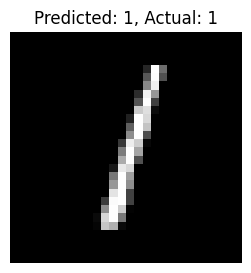

In [79]:
# Test on a few examples
print("Example predictions:")
test_prediction(0, X_test_nn, Y_test_nn, W1, b1, W2, b2)
test_prediction(1, X_test_nn, Y_test_nn, W1, b1, W2, b2)
test_prediction(2, X_test_nn, Y_test_nn, W1, b1, W2, b2)

### Comparing KNN vs Neural Network

In [ ]:
print("Final accuracies:")
print(f"KNN: {KNN_accuracy:.2%}")
print(f"NN accuracy: {test_accuracy:.2%}")


Final accuracies:
KNN: 87.30%
NN accuracy: 80.10%
